# Deep learning model with data augmentation for the blood dataset

In [11]:
from __future__ import print_function

#Basic libraries
import os
import numpy as np
#import pandas as pd
import tensorflow as tf
print('Tensorflow version: ', tf.__version__)

import random
import time

#Show images
import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image

data_path = './data/blood_cells_classification'

Tensorflow version:  1.8.0


In [2]:
# List categories in train data
categories = sorted(os.listdir(os.path.join(data_path, 'train')))
categories


['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

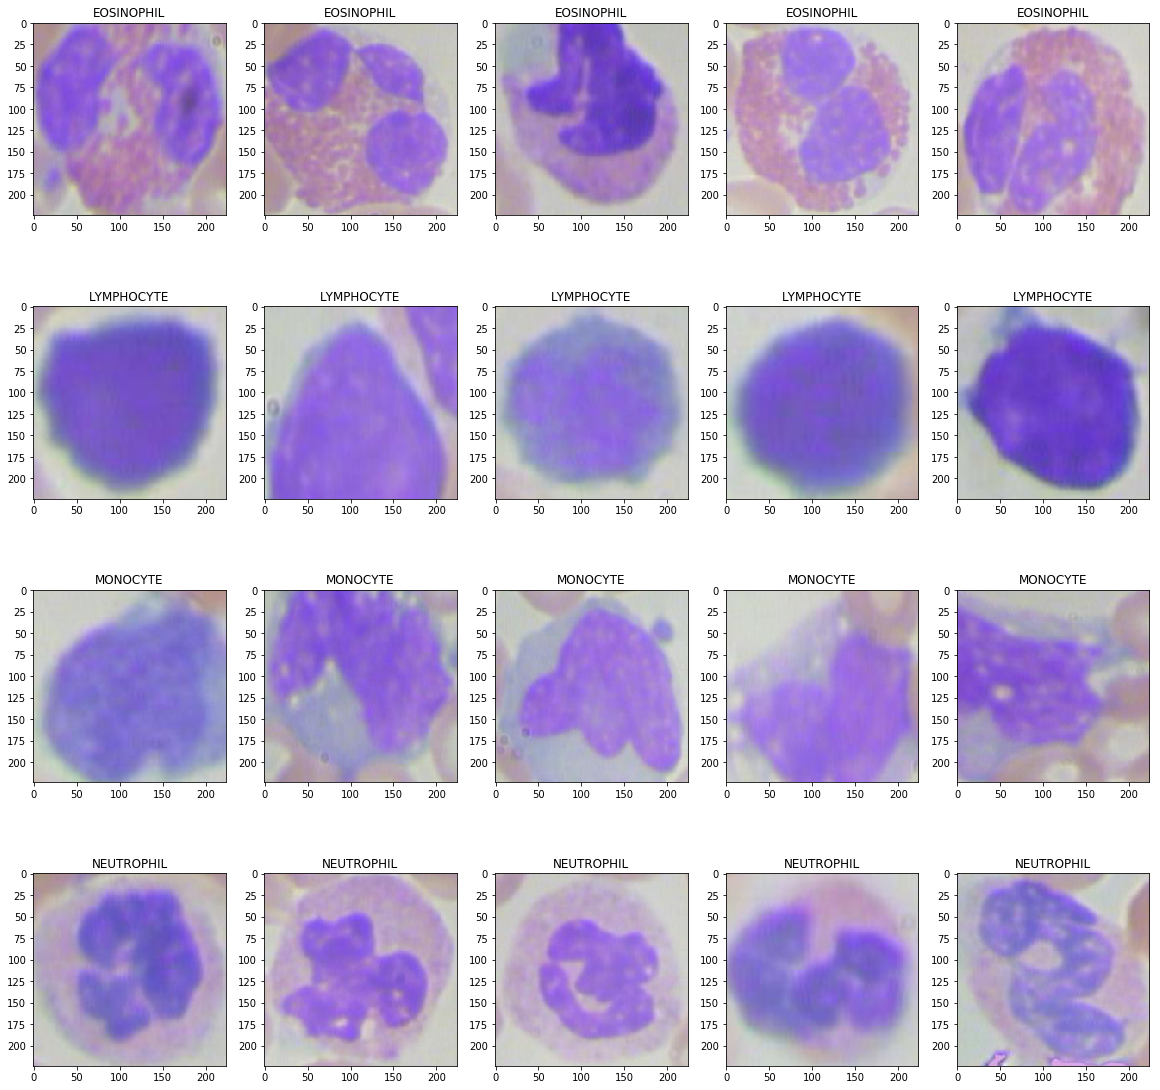

In [3]:
# Examine the data
plt.rcParams['figure.figsize'] = (20, 20) 

fig = plt.figure()
n=0
for i, category in enumerate(categories):
    filelist = [f for f in os.listdir(os.path.join(data_path, 'train', category)) if os.path.isfile(os.path.join(data_path, 'train', category, f))]
    random.shuffle(filelist) # Randomize images
    for f in filelist[:5]: 
        n += 1
        a = fig.add_subplot(4, 5, n)
        a.set_title(category)
        img = plt.imread(os.path.join(data_path, 'train', category, f))
        plt.imshow(img)
    

    

# Model 

In [4]:
# Build the model


#Inputs
images = tf.keras.layers.Input(batch_shape=(None, 64, 64, 3), dtype='float32', name='Images')

#First convolutional layer
conv11 = tf.keras.layers.Conv2D(32, (3,3), padding='valid', activation='relu')(images)
conv12 = tf.keras.layers.Conv2D(32, (3,3), padding='valid', activation='relu')(conv11)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv12)

#Second convolutional layer
conv21 = tf.keras.layers.Conv2D(64, (3,3), padding='valid', activation='relu')(pool1)
conv22 = tf.keras.layers.Conv2D(64, (3,3), padding='valid', activation='relu')(conv21)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv22)
#pool2d = tf.keras.layers.Dropout(0.5)(pool2)

#Dense layers
flat = tf.keras.layers.Flatten()(pool2)
dense1 = tf.keras.layers.Dense(256, activation='relu', name='Dense_1')(flat)
dense1d = tf.keras.layers.Dropout(0.5)(dense1)
output = tf.keras.layers.Dense(4, activation='softmax', name='Dense_output')(dense1d)


# Model Architecture defined
model = tf.keras.models.Model(inputs=images, outputs=output)
model.summary()

# Select optimizer and compile model
opt = tf.keras.optimizers.RMSprop(lr=0.002, decay=1e-3)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Images (InputLayer)          (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 26, 26, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 64)        0         
__________

# Data augmentation

In [5]:
batch_size = 16

# Augmentation for training
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=90,
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,
    vertical_flip=True
)

# Augmentation configuration we will use for testing: only rescaling
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)



# Define the generators from directory
# Change the target size to 32x32

train_generator = train_datagen.flow_from_directory(
    os.path.join(data_path, 'train'),
    target_size=(64, 64),
    batch_size=batch_size)

test_generator = test_datagen.flow_from_directory(
    os.path.join(data_path, 'test'),
    target_size=(64, 64),
    batch_size=batch_size)


Found 314 images belonging to 4 classes.
Found 32 images belonging to 4 classes.


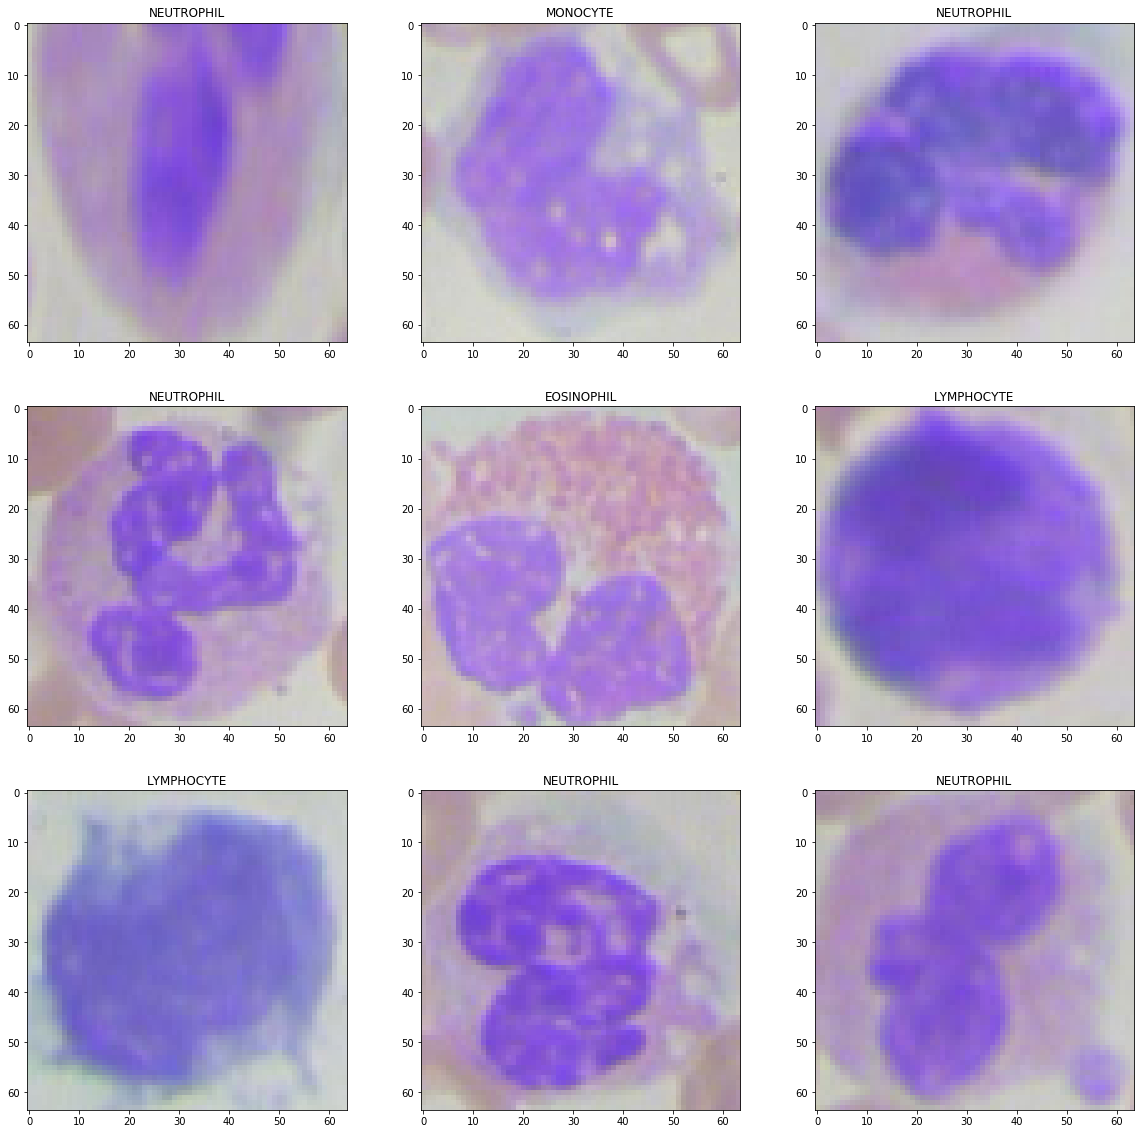

In [6]:
#Sanity chech of the data generators
gen_data = next(test_generator)
# Return a batch of pairs (image, label)

fig = plt.figure()
n=0
for i in range(9):
    n += 1
    a = fig.add_subplot(3, 3, n)
    a.set_title(categories[np.argmax(gen_data[1][i])])
    plt.imshow(gen_data[0][i])


In [7]:
# TRain the model using the fit_generator keras function
nb_train_samples = 314
nb_test_samples = 32
epochs = 100

tb_callback_ln = tf.keras.callbacks.TensorBoard(log_dir='./tensorboard/blood/data_augmentation/')

history = model.fit_generator(
    train_generator,
    steps_per_epoch = nb_train_samples // batch_size,
    epochs = epochs,
    validation_data = test_generator,
    validation_steps = nb_test_samples // batch_size,
    callbacks=[tb_callback_ln])


Epoch 1/100
19/19 [==============================] - 2s 92ms/step - loss: 1.9308 - acc: 0.5894 - val_loss: 1.2739 - val_acc: 0.4062
Epoch 2/100
19/19 [==============================] - 1s 78ms/step - loss: 1.0848 - acc: 0.6204 - val_loss: 1.3232 - val_acc: 0.4062
Epoch 3/100
19/19 [==============================] - 1s 79ms/step - loss: 1.0686 - acc: 0.6283 - val_loss: 1.2879 - val_acc: 0.4062
Epoch 4/100
19/19 [==============================] - 1s 77ms/step - loss: 1.0700 - acc: 0.6505 - val_loss: 1.3005 - val_acc: 0.4062
Epoch 5/100
19/19 [==============================] - 1s 71ms/step - loss: 1.1078 - acc: 0.6196 - val_loss: 1.3361 - val_acc: 0.4062
Epoch 6/100
19/19 [==============================] - 1s 73ms/step - loss: 1.0411 - acc: 0.6414 - val_loss: 1.3072 - val_acc: 0.4062
Epoch 7/100
19/19 [==============================] - 1s 71ms/step - loss: 1.0811 - acc: 0.6252 - val_loss: 1.3211 - val_acc: 0.4062
Epoch 8/100
19/19 [==============================] - 1s 72ms/step - loss: 1.

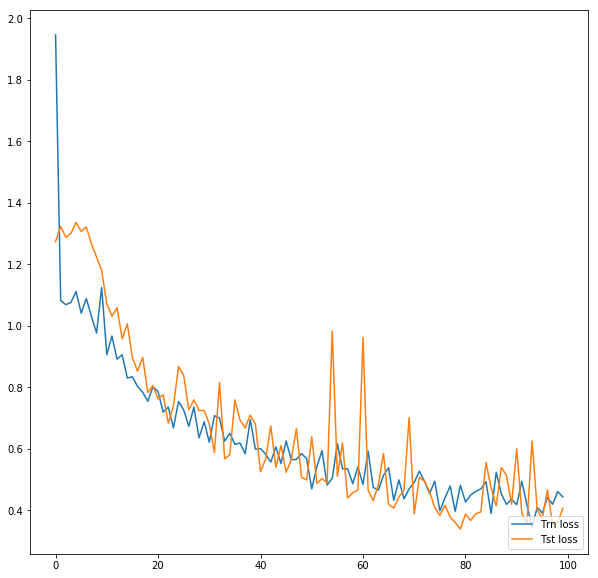

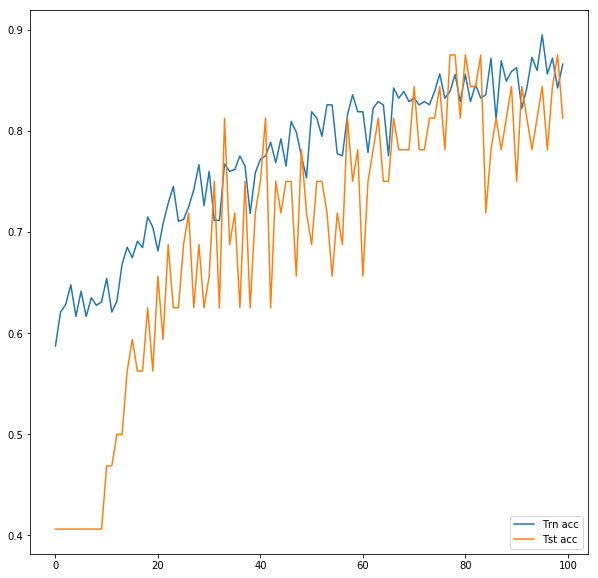

In [8]:
# Plot history
plt.rcParams['figure.figsize'] = (10, 10)        # size of images

plt.plot(history.history['loss'], label='Trn loss')
plt.plot(history.history['val_loss'], label='Tst loss')
plt.legend(loc='lower right')
plt.show()

plt.plot(history.history['acc'], label='Trn acc')
plt.plot(history.history['val_acc'], label='Tst acc')
plt.legend(loc='lower right')
plt.show()

# Sore test data and calculate the confusion matrix

In [12]:
def load_data(data_path):
    X = []
    y = []
    for c in os.listdir(data_path):
        for f in os.listdir(os.path.join(data_path,c)):
            im = Image.open(os.path.join(data_path, c, f))
            im = im.resize((64,64))
            img = np.array(im)
            X += [img[:,:,:3]]
            y += [c]
    return np.array(X), np.array(y)

X_tst, y_tst_txt = load_data(os.path.join(data_path, 'test'))
print(X_tst.shape)
print(y_tst_txt.shape)

(32, 64, 64, 3)
(32,)


In [13]:
# Score and select prediction with max prob
p_test = model.predict(X_tst)
pred_test = np.argmax(p_test, axis=1)

#Evaluate the confusion matrix
from sklearn.metrics import confusion_matrix
print(categories)
print(confusion_matrix(y_tst_txt, [categories[i] for i in pred_test]))

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
[[ 0  1  0  9]
 [ 0  6  0  0]
 [ 0  2  0  1]
 [ 0  0  0 13]]
